# Análisis de Coeficientes de Mezcla β para Retrasos de Vuelos

Este notebook implementa el estimador de McDonald (2015) para calcular coeficientes de mezcla β usando datos **diarios** de retrasos de vuelos de 2025.

## Objetivos:
1. Crear series temporales diarias de proporción de retrasos
2. Implementar el estimador β^d(a) con histogramas multidimensionales
3. Analizar convergencia del estimador para n creciente
4. Comparar comportamiento general vs. aeropuerto LAX específicamente

## Metodología:
- **Variable**: proporción_t = (delays del día t) / (total vuelos del día t)
- **Periodo**: Enero-Julio 2025 (~212 días)
- **Lags**: a ∈ {1, 2, 3, 4, 5} días
- **Convergencia**: n ∈ {100, 120, 140, 160, 180, 200, 212} días

## 1. Importar Librerías

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de ruta para guardar imágenes
ruta_imagenes = Path('../ProjectoCadenas/images')
ruta_imagenes.mkdir(parents=True, exist_ok=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

print("✓ Librerías cargadas")
print(f"✓ Ruta de imágenes configurada: {ruta_imagenes}")

✓ Librerías cargadas
✓ Ruta de imágenes configurada: ../ProjectoCadenas/images


## 3. Crear Serie Temporal Diaria (General)

Agregamos todos los vuelos por día para calcular la proporción de retrasos.

SERIE TEMPORAL DIARIA (GENERAL)
Número de días: 212

Estadísticas de proporción de delays:
count    212.000000
mean       0.221918
std        0.078819
min        0.058827
25%        0.158848
50%        0.215440
75%        0.287502
max        0.420321
Name: proporcion_delay, dtype: float64


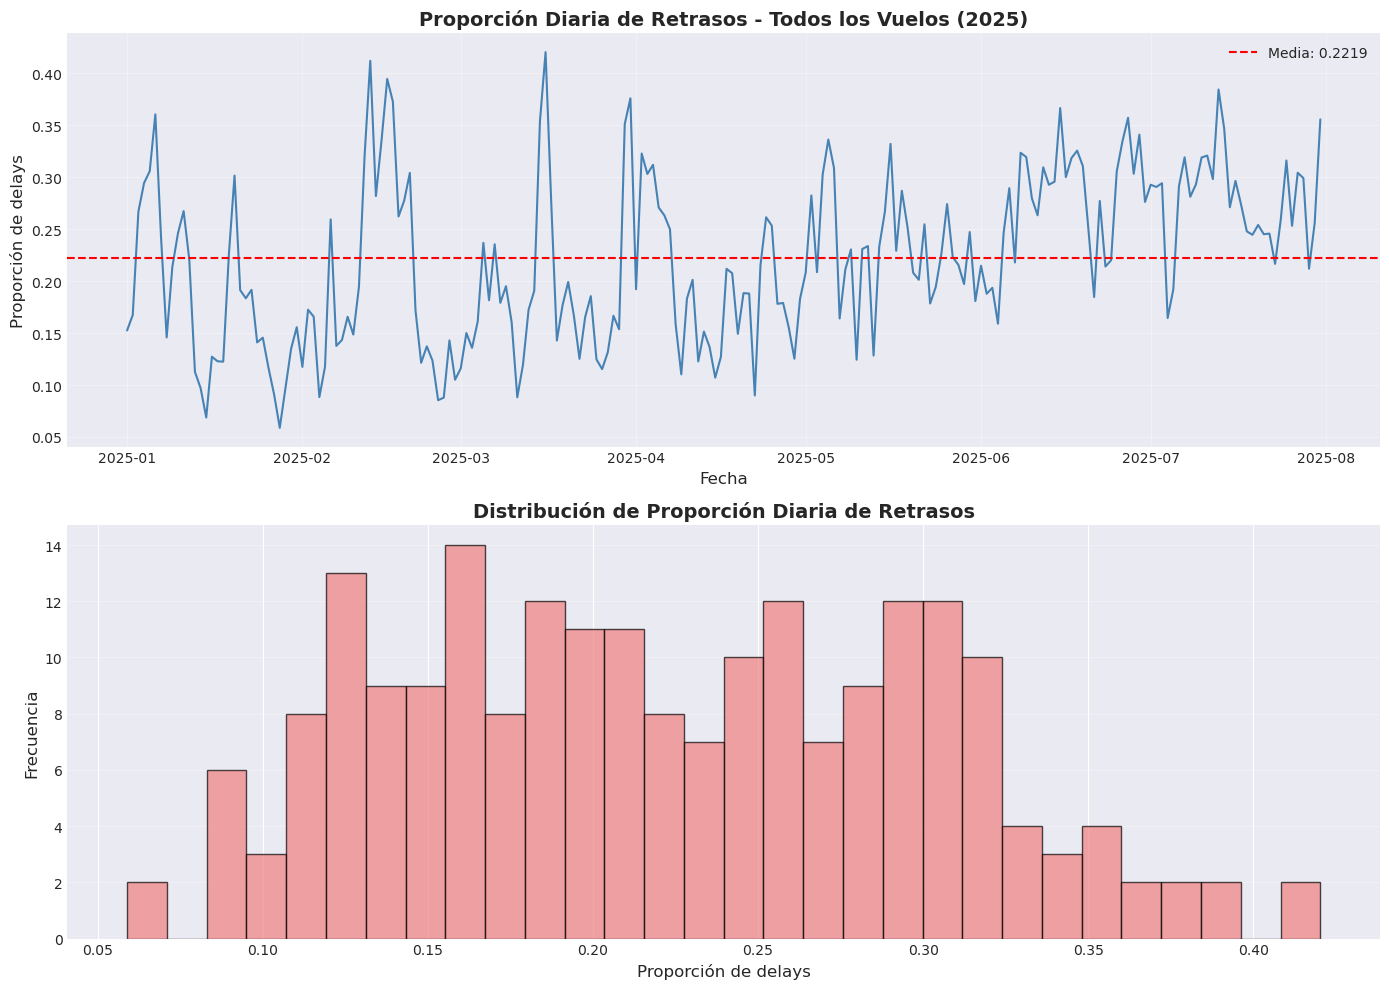


Primeros 10 días:
            ARR_DEL15  total_vuelos  proporcion_delay
FL_DATE                                              
2025-01-01     2566.0         16827          0.152493
2025-01-02     3285.0         19640          0.167261
2025-01-03     5165.0         19358          0.266815
2025-01-04     5458.0         18544          0.294327
2025-01-05     6014.0         19676          0.305652
2025-01-06     6752.0         18732          0.360453
2025-01-07     3877.0         15974          0.242707
2025-01-08     2373.0         16276          0.145797
2025-01-09     3833.0         17952          0.213514
2025-01-10     4398.0         17873          0.246069


In [99]:
# Agregar por fecha: sumar todas las aerolíneas y aeropuertos
serie_diaria = df_total.groupby('FL_DATE').agg({
    'ARR_DEL15': 'sum',      # Total de vuelos retrasados
    'FL_DATE': 'count'        # Total de vuelos (usando FL_DATE como contador)
}).rename(columns={'FL_DATE': 'total_vuelos'})

# Calcular proporción de retrasos
serie_diaria['proporcion_delay'] = serie_diaria['ARR_DEL15'] / serie_diaria['total_vuelos']

# Ordenar por fecha
serie_diaria = serie_diaria.sort_index()

print("=" * 80)
print("SERIE TEMPORAL DIARIA (GENERAL)")
print("=" * 80)
print(f"Número de días: {len(serie_diaria)}")
print(f"\nEstadísticas de proporción de delays:")
print(serie_diaria['proporcion_delay'].describe())

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Serie temporal
axes[0].plot(serie_diaria.index, serie_diaria['proporcion_delay'], linewidth=1.5, color='steelblue')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Proporción de delays', fontsize=12)
axes[0].set_title('Proporción Diaria de Retrasos - Todos los Vuelos (2025)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=serie_diaria['proporcion_delay'].mean(), color='red', linestyle='--', 
                label=f'Media: {serie_diaria["proporcion_delay"].mean():.4f}')
axes[0].legend()

# Histograma
axes[1].hist(serie_diaria['proporcion_delay'], bins=30, edgecolor='black', color='lightcoral', alpha=0.7)
axes[1].set_xlabel('Proporción de delays', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Proporción Diaria de Retrasos', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nPrimeros 10 días:")
print(serie_diaria.head(10))

## 4. Crear Serie Temporal Diaria (LAX)

Análisis específico para el aeropuerto de Los Angeles (LAX).

SERIE TEMPORAL DIARIA (GENERAL)
Número de días: 212

Estadísticas de proporción de delays:
count    212.000000
mean       0.221918
std        0.078819
min        0.058827
25%        0.158848
50%        0.215440
75%        0.287502
max        0.420321
Name: proporcion_delay, dtype: float64


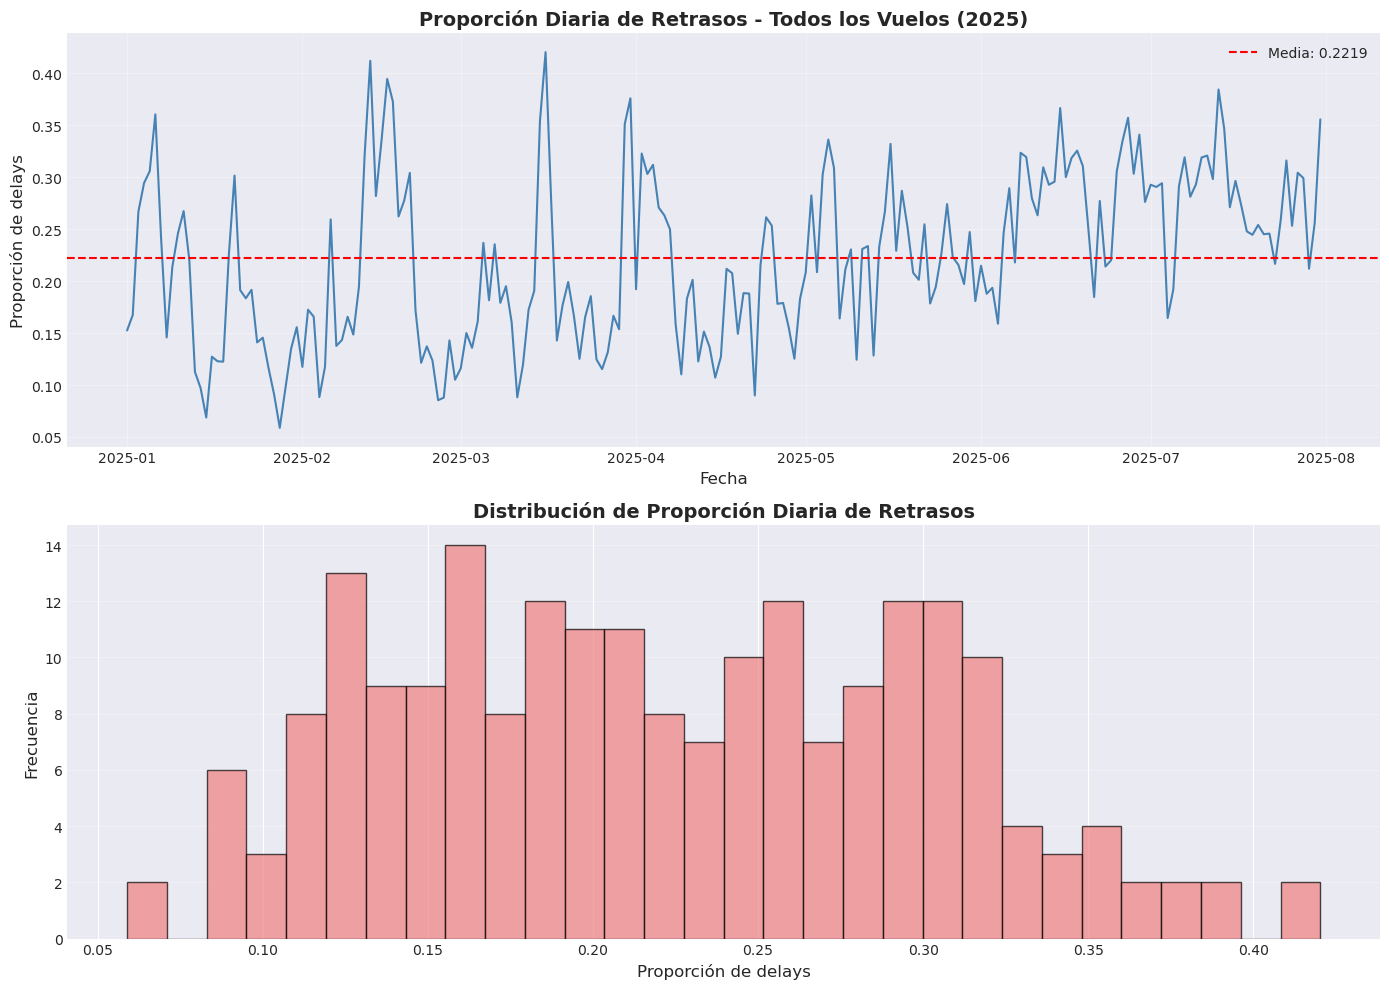


✓ Figura guardada: ../ProjectoCadenas/images/beta_delays_serie_temporal.png

Primeros 10 días:
            ARR_DEL15  total_vuelos  proporcion_delay
FL_DATE                                              
2025-01-01     2566.0         16827          0.152493
2025-01-02     3285.0         19640          0.167261
2025-01-03     5165.0         19358          0.266815
2025-01-04     5458.0         18544          0.294327
2025-01-05     6014.0         19676          0.305652
2025-01-06     6752.0         18732          0.360453
2025-01-07     3877.0         15974          0.242707
2025-01-08     2373.0         16276          0.145797
2025-01-09     3833.0         17952          0.213514
2025-01-10     4398.0         17873          0.246069


In [100]:
# Agregar por fecha: sumar todas las aerolíneas y aeropuertos
serie_diaria = df_total.groupby('FL_DATE').agg({
    'ARR_DEL15': 'sum',      # Total de vuelos retrasados
    'FL_DATE': 'count'        # Total de vuelos (usando FL_DATE como contador)
}).rename(columns={'FL_DATE': 'total_vuelos'})

# Calcular proporción de retrasos
serie_diaria['proporcion_delay'] = serie_diaria['ARR_DEL15'] / serie_diaria['total_vuelos']

# Ordenar por fecha
serie_diaria = serie_diaria.sort_index()

print("=" * 80)
print("SERIE TEMPORAL DIARIA (GENERAL)")
print("=" * 80)
print(f"Número de días: {len(serie_diaria)}")
print(f"\nEstadísticas de proporción de delays:")
print(serie_diaria['proporcion_delay'].describe())

# Visualización
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Serie temporal
axes[0].plot(serie_diaria.index, serie_diaria['proporcion_delay'], linewidth=1.5, color='steelblue')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Proporción de delays', fontsize=12)
axes[0].set_title('Proporción Diaria de Retrasos - Todos los Vuelos (2025)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].axhline(y=serie_diaria['proporcion_delay'].mean(), color='red', linestyle='--', 
                label=f'Media: {serie_diaria["proporcion_delay"].mean():.4f}')
axes[0].legend()

# Histograma
axes[1].hist(serie_diaria['proporcion_delay'], bins=30, edgecolor='black', color='lightcoral', alpha=0.7)
axes[1].set_xlabel('Proporción de delays', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Proporción Diaria de Retrasos', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(ruta_imagenes / 'beta_delays_serie_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figura guardada: {ruta_imagenes / 'beta_delays_serie_temporal.png'}")
print(f"\nPrimeros 10 días:")
print(serie_diaria.head(10))

## 5. Implementar Estimador de McDonald

Clase para calcular el coeficiente β^d(a) usando histogramas multidimensionales.

Buscando código de LAX...
Aeropuertos de origen únicos (primeros 20):
ORIGIN_AIRPORT_ID
11298    185138
11292    183985
10397    182033
13930    180482
11057    118412
14107    117408
12892    111123
12889    109897
13204     95308
14747     94815
10721     83521
11278     83419
14771     83300
12953     77815
11433     70832
11618     68298
14869     68191
13303     67777
12266     67637
13487     65750
Name: count, dtype: int64

Vuelos relacionados con LAX: 222,235 (5.45% del total)
SERIE TEMPORAL DIARIA (LAX)
Número de días: 212

Estadísticas de proporción de delays en LAX:
count    212.000000
mean       0.174371
std        0.065345
min        0.040404
25%        0.123162
50%        0.174900
75%        0.223023
max        0.404537
Name: proporcion_delay, dtype: float64


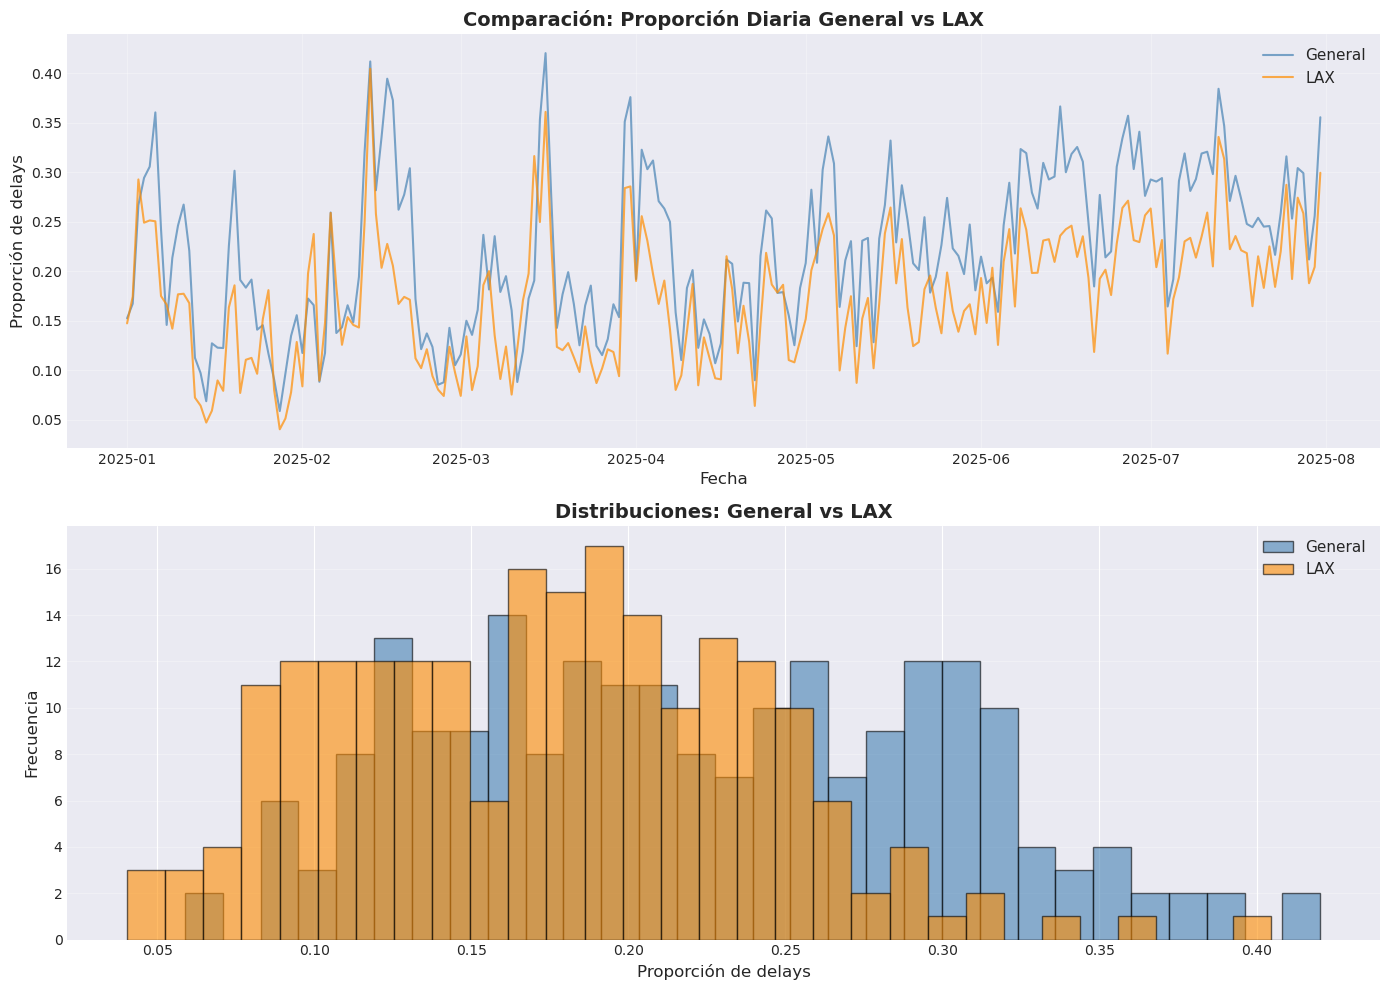

✓ Figura guardada: ../ProjectoCadenas/images/beta_delays_comparacion_series.png


In [101]:
# Identificar código de LAX
# LAX puede estar en ORIGIN_AIRPORT_ID o DEST_AIRPORT_ID
# Necesitamos encontrar el código correcto

print("Buscando código de LAX...")
print("Aeropuertos de origen únicos (primeros 20):")
print(df_total['ORIGIN_AIRPORT_ID'].value_counts().head(20))

# LAX típicamente tiene código 12892
codigo_lax = 12892

# Filtrar vuelos de LAX (origen o destino)
df_lax = df_total[
    (df_total['ORIGIN_AIRPORT_ID'] == codigo_lax) | 
    (df_total['DEST_AIRPORT_ID'] == codigo_lax)
]

print(f"\nVuelos relacionados con LAX: {len(df_lax):,} ({len(df_lax)/len(df_total)*100:.2f}% del total)")

# Agregar por fecha para LAX
serie_lax = df_lax.groupby('FL_DATE').agg({
    'ARR_DEL15': 'sum',
    'FL_DATE': 'count'
}).rename(columns={'FL_DATE': 'total_vuelos'})

serie_lax['proporcion_delay'] = serie_lax['ARR_DEL15'] / serie_lax['total_vuelos']
serie_lax = serie_lax.sort_index()

print("=" * 80)
print("SERIE TEMPORAL DIARIA (LAX)")
print("=" * 80)
print(f"Número de días: {len(serie_lax)}")
print(f"\nEstadísticas de proporción de delays en LAX:")
print(serie_lax['proporcion_delay'].describe())

# Visualización comparativa
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Comparación de series temporales
axes[0].plot(serie_diaria.index, serie_diaria['proporcion_delay'], 
            linewidth=1.5, alpha=0.7, label='General', color='steelblue')
axes[0].plot(serie_lax.index, serie_lax['proporcion_delay'], 
            linewidth=1.5, alpha=0.7, label='LAX', color='darkorange')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Proporción de delays', fontsize=12)
axes[0].set_title('Comparación: Proporción Diaria General vs LAX', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Comparación de distribuciones
axes[1].hist(serie_diaria['proporcion_delay'], bins=30, alpha=0.6, 
            label='General', color='steelblue', edgecolor='black')
axes[1].hist(serie_lax['proporcion_delay'], bins=30, alpha=0.6, 
            label='LAX', color='darkorange', edgecolor='black')
axes[1].set_xlabel('Proporción de delays', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribuciones: General vs LAX', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(ruta_imagenes / 'beta_delays_comparacion_series.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {ruta_imagenes / 'beta_delays_comparacion_series.png'}")

## 6. Función para Calcular d_n y h_n Adaptativos

Implementamos las funciones que determinan los parámetros según las condiciones de McDonald.

In [102]:
def calcular_d_n(n):
    """
    Calcula dimensión d_n que crece lentamente con n.
    
    Usamos: d_n = max(1, floor(log₂(n/20)))
    
    Esto asegura:
    - d_n = 1 para n < 40
    - d_n = 2 para n ∈ [40, 80)
    - d_n = 3 para n ∈ [80, 160)
    - etc.
    """
    return max(1, int(np.floor(np.log2(n / 20))))

def calcular_h_n(n, d_n):
    """
    Calcula ancho de bins óptimo según McDonald.
    
    h_n = n^(-1/(2d_n + 1))
    """
    return n**(-1 / (2*d_n + 1))

def verificar_condiciones_mcdonald(n, d_n, h_n):
    """
    Verifica las 4 condiciones de convergencia de McDonald:
    
    1. n * h_n^{d_n} → ∞
    2. d_n * h_n → 0
    3. d_n → ∞ (cuando n → ∞)
    4. h_n → 0
    
    Retorna:
    --------
    dict con valores de cada condición
    """
    cond1 = n * (h_n ** d_n)
    cond2 = d_n * h_n
    cond3 = d_n
    cond4 = h_n
    
    return {
        'n': n,
        'd_n': d_n,
        'h_n': h_n,
        'nh_n^d_n': cond1,
        'd_n*h_n': cond2,
        'd_n': cond3,
        'h_n': cond4
    }

# Ejemplo de evolución de parámetros
print("Evolución de parámetros d_n y h_n:")
print("=" * 80)
print(f"{'n':>6s} {'d_n':>6s} {'h_n':>12s} {'nh_n^d_n':>15s} {'d_n*h_n':>12s}")
print("=" * 80)

for n in [50, 100, 150, 200, 250]:
    d_n = calcular_d_n(n)
    h_n = calcular_h_n(n, d_n)
    condiciones = verificar_condiciones_mcdonald(n, d_n, h_n)
    
    print(f"{n:6d} {d_n:6d} {h_n:12.6f} {condiciones['nh_n^d_n']:15.6f} {condiciones['d_n*h_n']:12.6f}")

print("=" * 80)
print("✓ Funciones de parámetros adaptativos implementadas")

Evolución de parámetros d_n y h_n:
     n    d_n          h_n        nh_n^d_n      d_n*h_n
    50      1     0.271442       13.572088     0.271442
   100      2     0.398107       15.848932     0.796214
   150      2     0.367098       20.214116     0.734196
   200      3     0.469117       20.647824     1.407352
   250      3     0.454399       23.455864     1.363196
✓ Funciones de parámetros adaptativos implementadas


## 7. Análisis de Convergencia (General)

Calculamos β^{d_n}(a) para diferentes tamaños de muestra n y lags a.

In [103]:
# Extraer array de proporción de delays
datos_general = serie_diaria['proporcion_delay'].values

# Configuración del análisis
tamaños_muestra = [100, 120, 140, 160, 180, 200, len(datos_general)]  # n values
lags = [1, 2, 3, 4, 5]  # a values

print("="* 80)
print("ANÁLISIS DE CONVERGENCIA - DATOS GENERALES")
print("=" * 80)
print(f"Total de días disponibles: {len(datos_general)}")
print(f"Tamaños de muestra a analizar: {tamaños_muestra}")
print(f"Lags (días): {lags}")
print("=" * 80)

# Matriz para almacenar resultados: β[i, j] = β^{d_n}(a) para n=tamaños_muestra[i], a=lags[j]
beta_general = np.zeros((len(tamaños_muestra), len(lags)))
parametros_general = []  # Lista de diccionarios con parámetros

# Calcular β para cada combinación de n y a
for i, n in enumerate(tamaños_muestra):
    # Tomar primeros n días
    datos_n = datos_general[:n]
    
    # Calcular parámetros adaptativos
    d_n = calcular_d_n(n)
    h_n = calcular_h_n(n, d_n)
    
    # Verificar condiciones
    condiciones = verificar_condiciones_mcdonald(n, d_n, h_n)
    parametros_general.append(condiciones)
    
    # Crear estimador
    estimador = EstimadorBetaMcDonald(datos_n)
    
    print(f"\nn = {n:3d}, d_n = {d_n}, h_n = {h_n:.6f}")
    print(f"  Condiciones: nh_n^d_n = {condiciones['nh_n^d_n']:.4f}, d_n*h_n = {condiciones['d_n*h_n']:.6f}")
    print(f"  β^{d_n}(a): ", end="")
    
    # Calcular β para cada lag
    for j, a in enumerate(lags):
        beta_hat = estimador.estimar_beta(d=d_n, a=a, h_n=h_n)
        beta_general[i, j] = beta_hat
        print(f"a={a}: {beta_hat:.6f}  ", end="")
    print()

print("\n" + "=" * 80)
print("✓ Análisis de convergencia completado")

# Crear DataFrame con resultados
df_beta_general = pd.DataFrame(
    beta_general,
    index=[f"n={n}" for n in tamaños_muestra],
    columns=[f"a={a}" for a in lags]
)

print("\nTabla de β^{d_n}(a):")
print(df_beta_general.to_string())

ANÁLISIS DE CONVERGENCIA - DATOS GENERALES
Total de días disponibles: 212
Tamaños de muestra a analizar: [100, 120, 140, 160, 180, 200, 212]
Lags (días): [1, 2, 3, 4, 5]

n = 100, d_n = 2, h_n = 0.398107
  Condiciones: nh_n^d_n = 15.8489, d_n*h_n = 0.796214
  β^2(a): a=1: 0.754955  a=2: 0.442164  a=3: 0.355023  a=4: 0.185289  a=5: 0.009784  

n = 120, d_n = 2, h_n = 0.383852
  Condiciones: nh_n^d_n = 17.6811, d_n*h_n = 0.767704
  β^2(a): a=1: 0.735595  a=2: 0.416858  a=3: 0.346492  a=4: 0.179697  a=5: 0.016858  

n = 140, d_n = 2, h_n = 0.372198
  Condiciones: nh_n^d_n = 19.3944, d_n*h_n = 0.744397
  β^2(a): a=1: 0.708628  a=2: 0.407799  a=3: 0.345597  a=4: 0.176483  a=5: 0.035382  

n = 160, d_n = 3, h_n = 0.484313
  Condiciones: nh_n^d_n = 18.1760, d_n*h_n = 1.452938
  β^3(a): a=1: 0.762234  a=2: 0.442126  a=3: 0.381185  a=4: 0.199292  a=5: 0.042574  

n = 180, d_n = 3, h_n = 0.476232
  Condiciones: nh_n^d_n = 19.4414, d_n*h_n = 1.428695
  β^3(a): a=1: 0.809869  a=2: 0.535164  a=3: 0

## 8. Visualización de Convergencia (General)

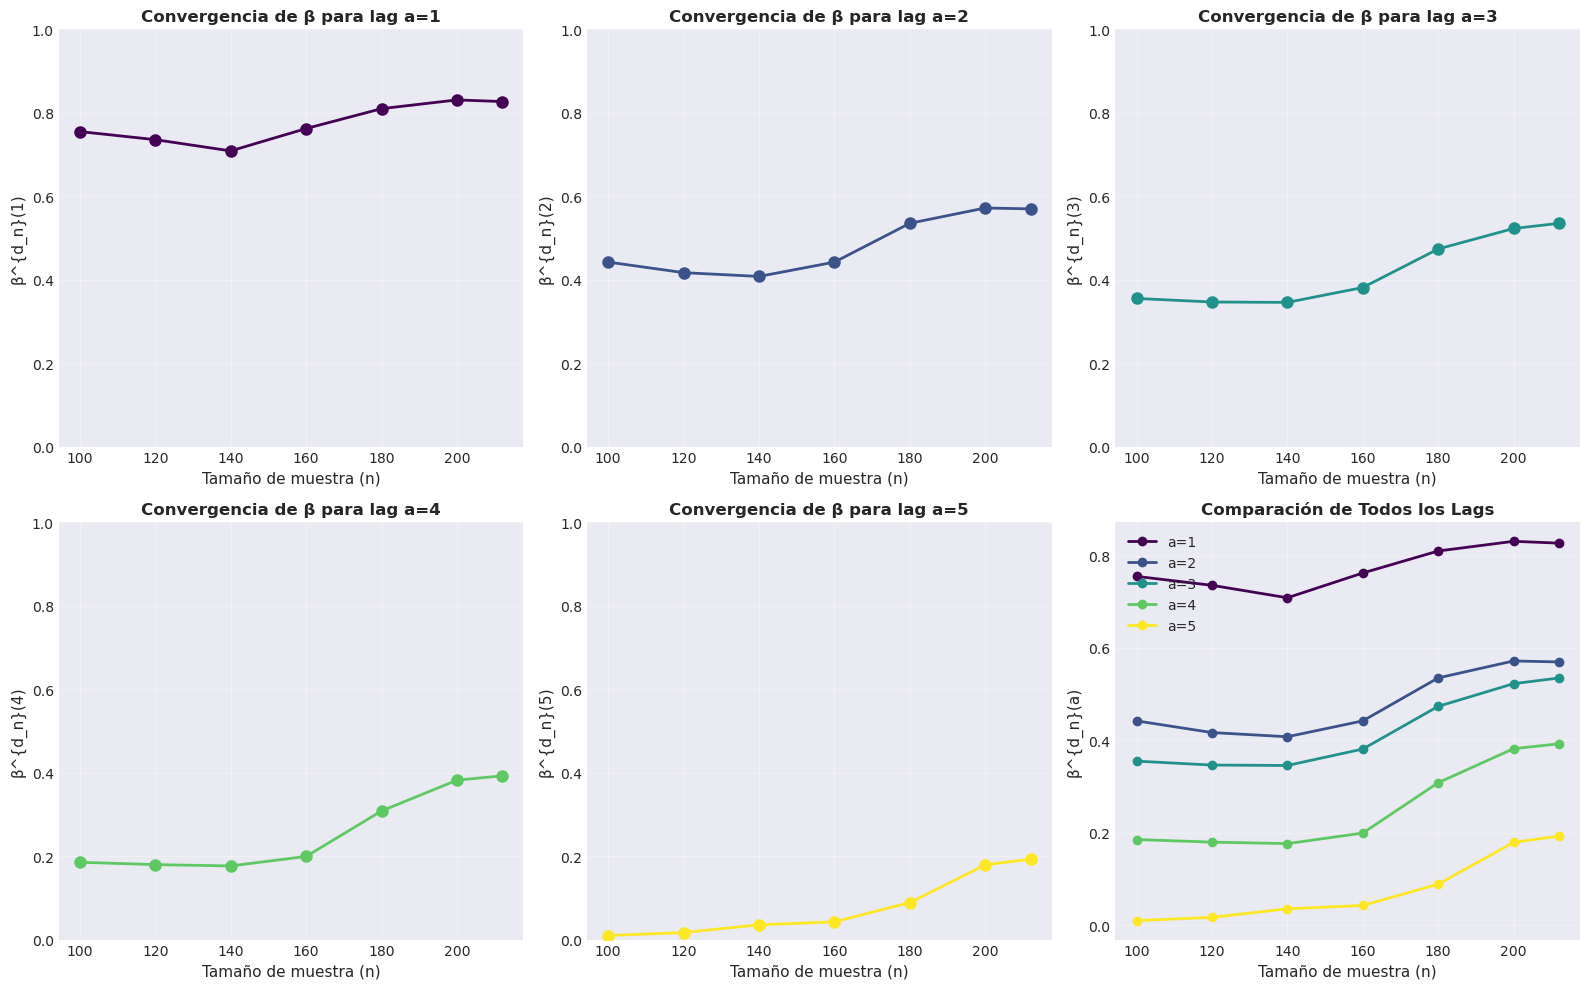

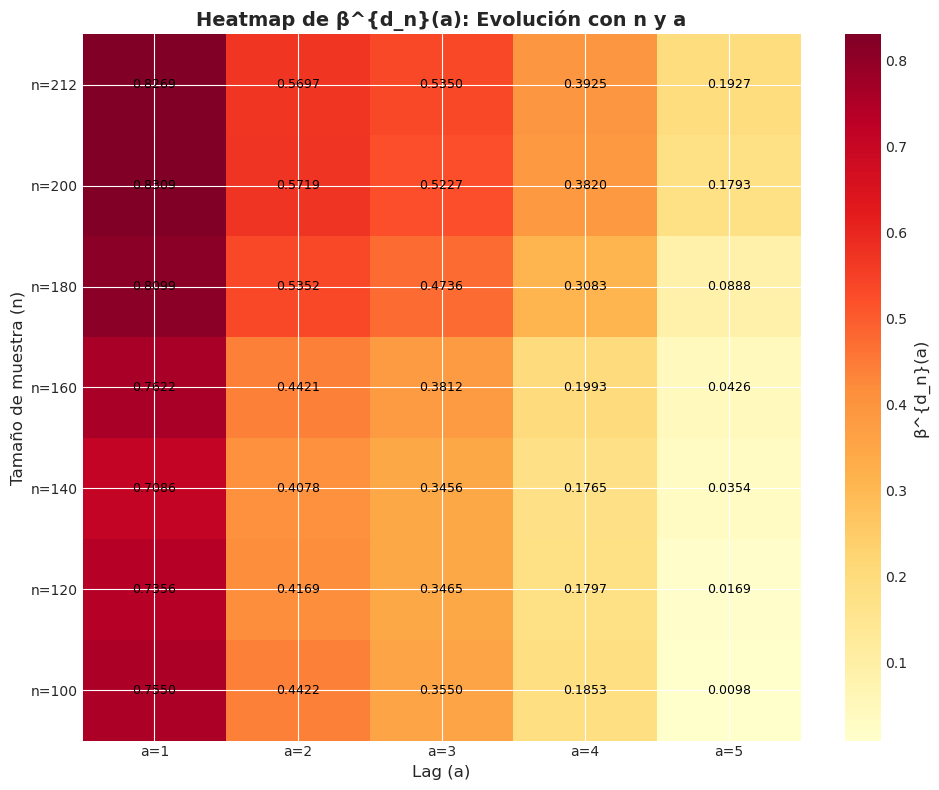

In [104]:
# Gráfico 1: Evolución de β(a) vs n para cada lag
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

colores = plt.cm.viridis(np.linspace(0, 1, len(lags)))

# Un subplot para cada lag
for j, a in enumerate(lags):
    ax = axes[j]
    ax.plot(tamaños_muestra, beta_general[:, j], marker='o', linewidth=2, 
           markersize=8, color=colores[j])
    ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
    ax.set_ylabel(f'β^{{d_n}}({a})', fontsize=11)
    ax.set_title(f'Convergencia de β para lag a={a}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_ylim([0, max(1, beta_general[:, j].max() * 1.1)])

# Subplot combinado
ax = axes[5]
for j, a in enumerate(lags):
    ax.plot(tamaños_muestra, beta_general[:, j], marker='o', linewidth=2, 
           markersize=6, label=f'a={a}', color=colores[j])
ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
ax.set_ylabel('β^{d_n}(a)', fontsize=11)
ax.set_title('Comparación de Todos los Lags', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Heatmap de β(n, a)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(beta_general, aspect='auto', cmap='YlOrRd', origin='lower')

# Configurar ticks
ax.set_xticks(np.arange(len(lags)))
ax.set_yticks(np.arange(len(tamaños_muestra)))
ax.set_xticklabels([f'a={a}' for a in lags])
ax.set_yticklabels([f'n={n}' for n in tamaños_muestra])

# Añadir valores en cada celda
for i in range(len(tamaños_muestra)):
    for j in range(len(lags)):
        text = ax.text(j, i, f'{beta_general[i, j]:.4f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Heatmap de β^{d_n}(a): Evolución con n y a', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (a)', fontsize=12)
ax.set_ylabel('Tamaño de muestra (n)', fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('β^{d_n}(a)', fontsize=12)

plt.tight_layout()
plt.show()

## 9. Análisis de Convergencia (LAX)

Repetimos el análisis para el aeropuerto LAX.

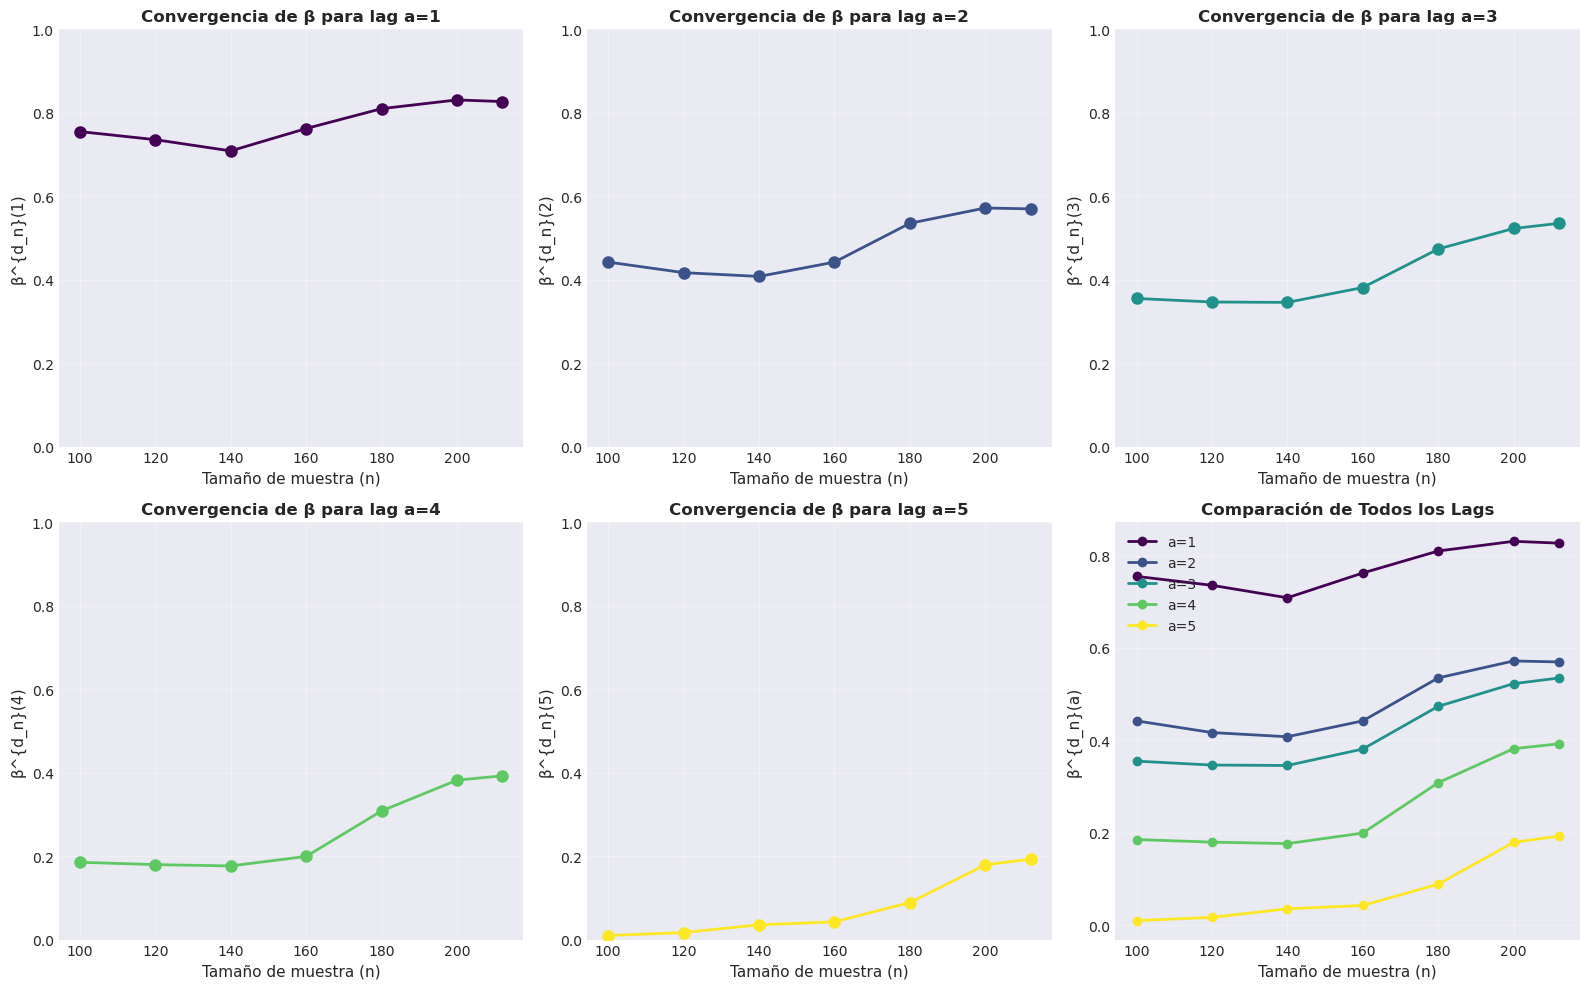

✓ Figura guardada: ../ProjectoCadenas/images/beta_delays_convergencia_lags.png


In [105]:
# Gráfico 1: Evolución de β(a) vs n para cada lag
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

colores = plt.cm.viridis(np.linspace(0, 1, len(lags)))

# Un subplot para cada lag
for j, a in enumerate(lags):
    ax = axes[j]
    ax.plot(tamaños_muestra, beta_general[:, j], marker='o', linewidth=2, 
           markersize=8, color=colores[j])
    ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
    ax.set_ylabel(f'β^{{d_n}}({a})', fontsize=11)
    ax.set_title(f'Convergencia de β para lag a={a}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_ylim([0, max(1, beta_general[:, j].max() * 1.1)])

# Subplot combinado
ax = axes[5]
for j, a in enumerate(lags):
    ax.plot(tamaños_muestra, beta_general[:, j], marker='o', linewidth=2, 
           markersize=6, label=f'a={a}', color=colores[j])
ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
ax.set_ylabel('β^{d_n}(a)', fontsize=11)
ax.set_title('Comparación de Todos los Lags', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_imagenes / 'beta_delays_convergencia_lags.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {ruta_imagenes / 'beta_delays_convergencia_lags.png'}")

# Nota: Omitimos el heatmap según petición del usuario

## 10. Comparación General vs LAX

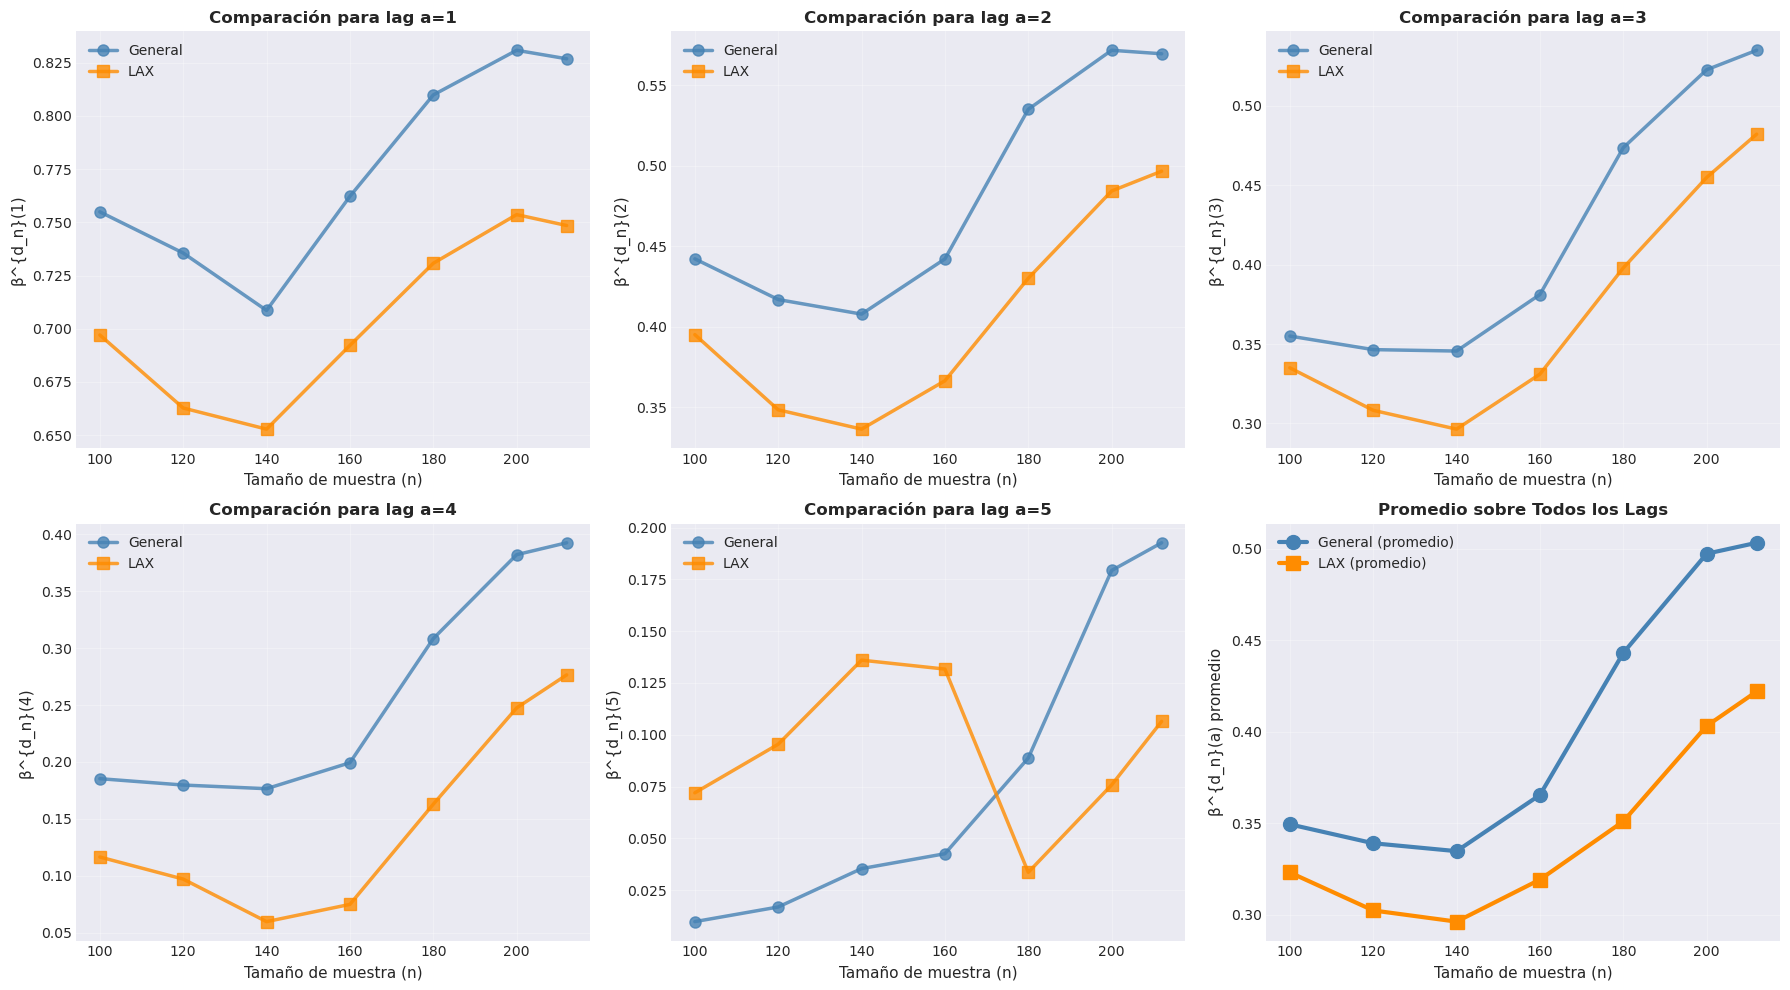


COMPARACIÓN GENERAL VS LAX - β^{d_n}(a) PARA n MÁXIMO
Lag  β General    β LAX  Diferencia
a=1   0.826870 0.748520    0.078350
a=2   0.569702 0.496687    0.073015
a=3   0.534964 0.482139    0.052826
a=4   0.392492 0.276442    0.116050
a=5   0.192687 0.106467    0.086221


In [106]:
# Comparación lado a lado
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

colores_gen = 'steelblue'
colores_lax = 'darkorange'

# Un subplot para cada lag
for j, a in enumerate(lags):
    ax = axes[j]
    ax.plot(tamaños_muestra, beta_general[:, j], marker='o', linewidth=2.5, 
           markersize=8, label='General', color=colores_gen, alpha=0.8)
    ax.plot(tamaños_muestra, beta_lax[:, j], marker='s', linewidth=2.5, 
           markersize=8, label='LAX', color=colores_lax, alpha=0.8)
    ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
    ax.set_ylabel(f'β^{{d_n}}({a})', fontsize=11)
    ax.set_title(f'Comparación para lag a={a}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

# Subplot combinado
ax = axes[5]
# Promediar sobre lags
beta_gen_avg = beta_general.mean(axis=1)
beta_lax_avg = beta_lax.mean(axis=1)

ax.plot(tamaños_muestra, beta_gen_avg, marker='o', linewidth=3, 
       markersize=10, label='General (promedio)', color=colores_gen)
ax.plot(tamaños_muestra, beta_lax_avg, marker='s', linewidth=3, 
       markersize=10, label='LAX (promedio)', color=colores_lax)
ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
ax.set_ylabel('β^{d_n}(a) promedio', fontsize=11)
ax.set_title('Promedio sobre Todos los Lags', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n" + "=" * 80)
print("COMPARACIÓN GENERAL VS LAX - β^{d_n}(a) PARA n MÁXIMO")
print("=" * 80)

df_comparacion = pd.DataFrame({
    'Lag': [f'a={a}' for a in lags],
    'β General': beta_general[-1, :],
    'β LAX': beta_lax[-1, :],
    'Diferencia': beta_general[-1, :] - beta_lax[-1, :]
})

print(df_comparacion.to_string(index=False))
print("=" * 80)

## 11. Verificación de Condiciones de McDonald

Verificamos que las condiciones de convergencia se cumplan.

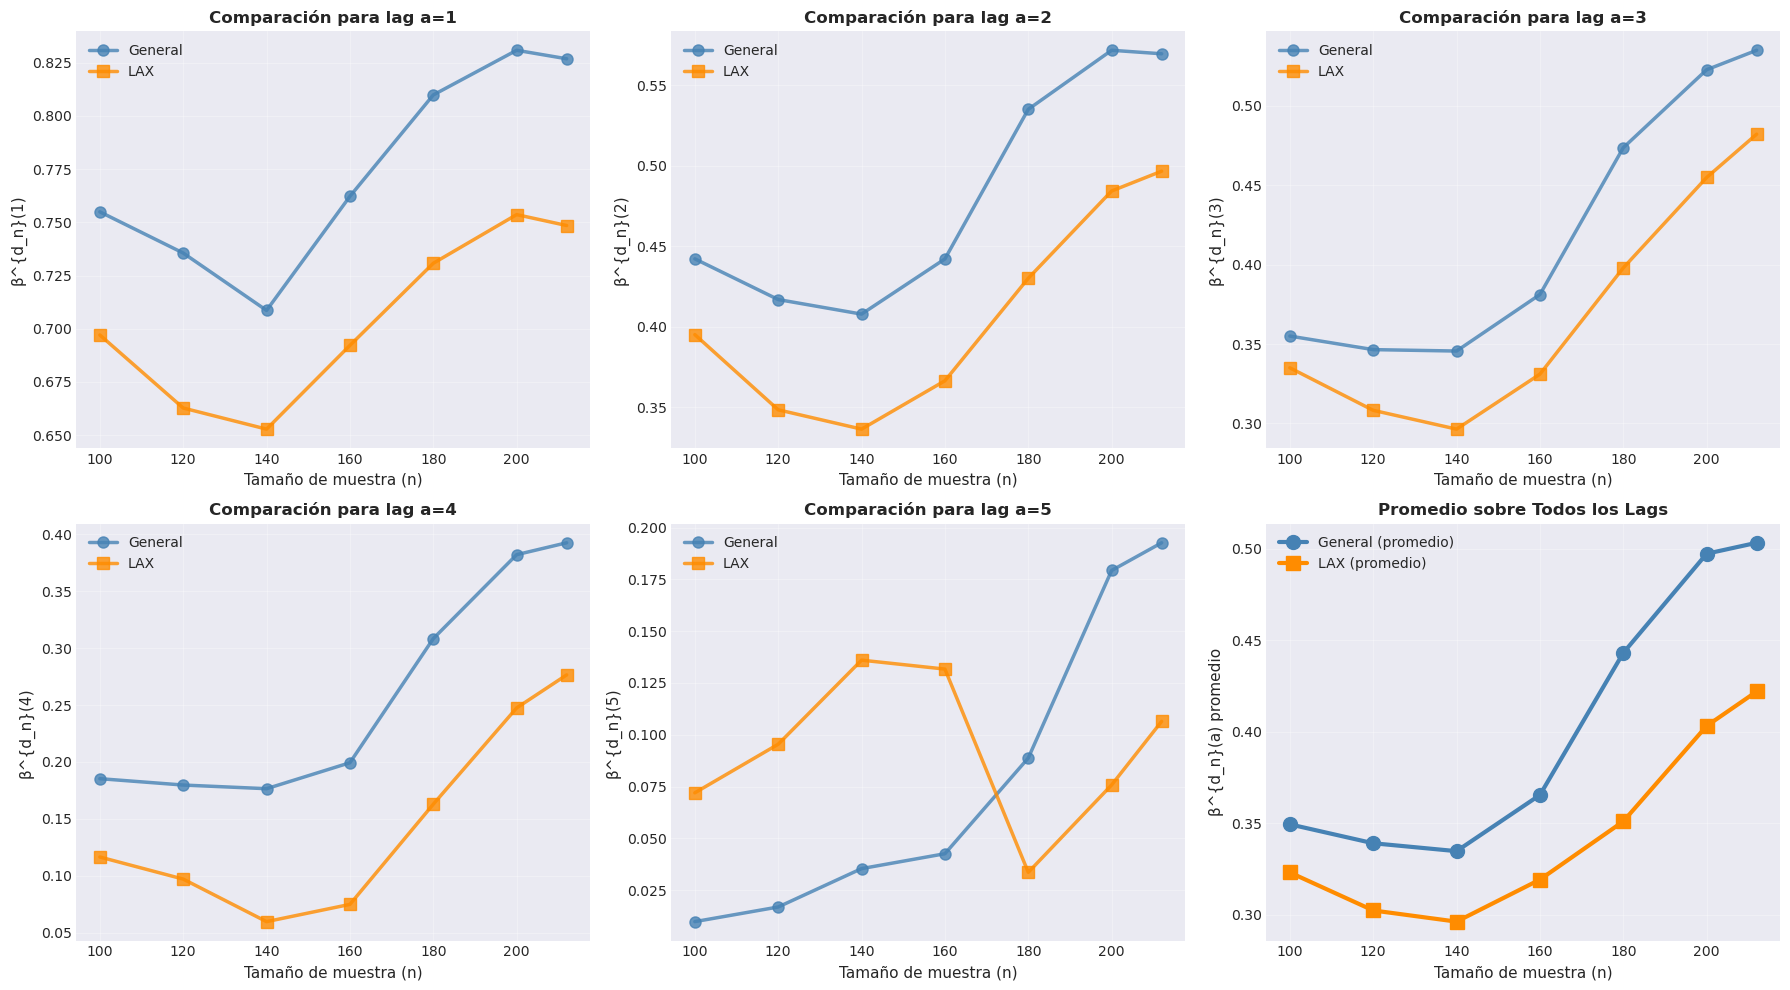

✓ Figura guardada: ../ProjectoCadenas/images/beta_delays_comparacion_general_lax.png

COMPARACIÓN GENERAL VS LAX - β^{d_n}(a) PARA n MÁXIMO
Lag  β General    β LAX  Diferencia
a=1   0.826870 0.748520    0.078350
a=2   0.569702 0.496687    0.073015
a=3   0.534964 0.482139    0.052826
a=4   0.392492 0.276442    0.116050
a=5   0.192687 0.106467    0.086221


In [107]:
# Comparación lado a lado
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

colores_gen = 'steelblue'
colores_lax = 'darkorange'

# Un subplot para cada lag
for j, a in enumerate(lags):
    ax = axes[j]
    ax.plot(tamaños_muestra, beta_general[:, j], marker='o', linewidth=2.5, 
           markersize=8, label='General', color=colores_gen, alpha=0.8)
    ax.plot(tamaños_muestra, beta_lax[:, j], marker='s', linewidth=2.5, 
           markersize=8, label='LAX', color=colores_lax, alpha=0.8)
    ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
    ax.set_ylabel(f'β^{{d_n}}({a})', fontsize=11)
    ax.set_title(f'Comparación para lag a={a}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

# Subplot combinado
ax = axes[5]
# Promediar sobre lags
beta_gen_avg = beta_general.mean(axis=1)
beta_lax_avg = beta_lax.mean(axis=1)

ax.plot(tamaños_muestra, beta_gen_avg, marker='o', linewidth=3, 
       markersize=10, label='General (promedio)', color=colores_gen)
ax.plot(tamaños_muestra, beta_lax_avg, marker='s', linewidth=3, 
       markersize=10, label='LAX (promedio)', color=colores_lax)
ax.set_xlabel('Tamaño de muestra (n)', fontsize=11)
ax.set_ylabel('β^{d_n}(a) promedio', fontsize=11)
ax.set_title('Promedio sobre Todos los Lags', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_imagenes / 'beta_delays_comparacion_general_lax.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figura guardada: {ruta_imagenes / 'beta_delays_comparacion_general_lax.png'}")

# Tabla comparativa
print("\n" + "=" * 80)
print("COMPARACIÓN GENERAL VS LAX - β^{d_n}(a) PARA n MÁXIMO")
print("=" * 80)

df_comparacion = pd.DataFrame({
    'Lag': [f'a={a}' for a in lags],
    'β General': beta_general[-1, :],
    'β LAX': beta_lax[-1, :],
    'Diferencia': beta_general[-1, :] - beta_lax[-1, :]
})

print(df_comparacion.to_string(index=False))
print("=" * 80)

## 12. Análisis de Decaimiento de β(a)

Para n máximo, verificamos si β(a) → 0 cuando a → ∞.

VERIFICACIÓN DE CONDICIONES DE CONVERGENCIA (McDonald 2015)

Condiciones:
  1. nh_n^{d_n} → ∞  (debe crecer)
  2. d_n * h_n → 0   (debe decrecer)
  3. d_n → ∞         (debe crecer)
  4. h_n → 0         (debe decrecer)

  n  d_n      h_n  nh_n^d_n  d_n*h_n
100    2 0.398107 15.848932 0.796214
120    2 0.383852 17.681078 0.767704
140    2 0.372198 19.394421 0.744397
160    3 0.484313 18.175951 1.452938
180    3 0.476232 19.441383 1.428695
200    3 0.469117 20.647824 1.407352
212    3 0.465228 21.346898 1.395685


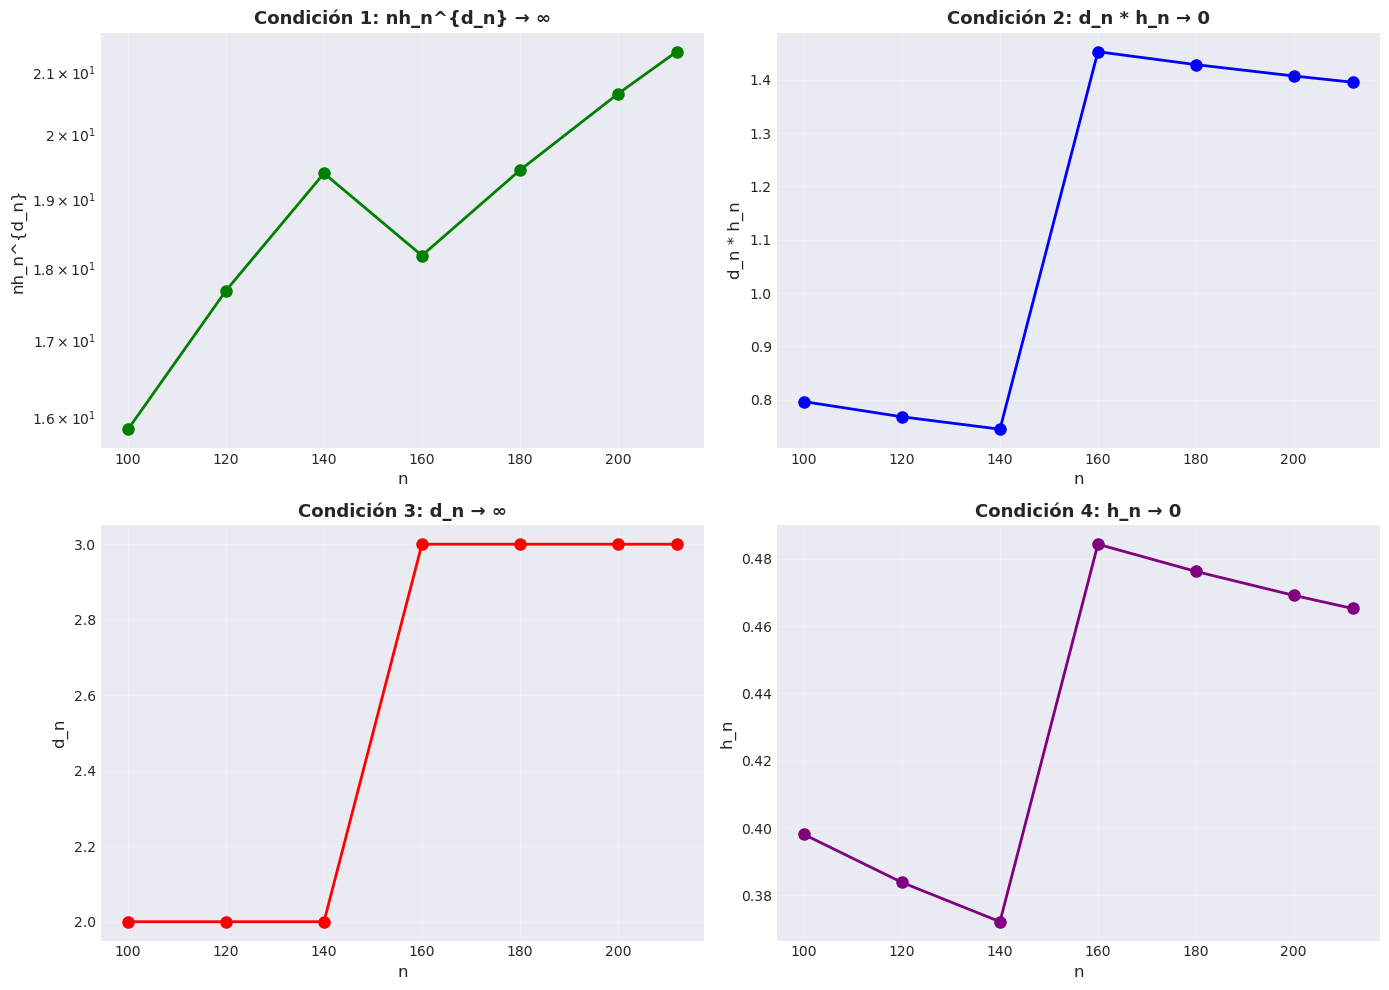


✓ Figura guardada: ../ProjectoCadenas/images/beta_delays_condiciones_mcdonald.png

VERIFICACIÓN DE TENDENCIAS
Condición 1 (nh_n^d_n crece): ✗ NO
Condición 2 (d_n*h_n decrece): ✗ NO
Condición 3 (d_n crece): ✓ SÍ
Condición 4 (h_n decrece): ✗ NO

⚠ ALGUNAS CONDICIONES NO SE CUMPLEN ESTRICTAMENTE
  (Esto puede ser normal para tamaños de muestra finitos)


In [108]:
# Crear DataFrame con parámetros
df_parametros = pd.DataFrame(parametros_general)

print("=" * 80)
print("VERIFICACIÓN DE CONDICIONES DE CONVERGENCIA (McDonald 2015)")
print("=" * 80)
print("\nCondiciones:")
print("  1. nh_n^{d_n} → ∞  (debe crecer)")
print("  2. d_n * h_n → 0   (debe decrecer)")
print("  3. d_n → ∞         (debe crecer)")
print("  4. h_n → 0         (debe decrecer)")
print("\n" + "=" * 80)
print(df_parametros.to_string(index=False))
print("=" * 80)

# Visualización de evolución de condiciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Condición 1: nh_n^{d_n}
axes[0, 0].plot(df_parametros['n'], df_parametros['nh_n^d_n'], 
               marker='o', linewidth=2, markersize=8, color='green')
axes[0, 0].set_xlabel('n', fontsize=12)
axes[0, 0].set_ylabel('nh_n^{d_n}', fontsize=12)
axes[0, 0].set_title('Condición 1: nh_n^{d_n} → ∞', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_yscale('log')

# Condición 2: d_n * h_n
axes[0, 1].plot(df_parametros['n'], df_parametros['d_n*h_n'], 
               marker='o', linewidth=2, markersize=8, color='blue')
axes[0, 1].set_xlabel('n', fontsize=12)
axes[0, 1].set_ylabel('d_n * h_n', fontsize=12)
axes[0, 1].set_title('Condición 2: d_n * h_n → 0', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Condición 3: d_n
axes[1, 0].plot(df_parametros['n'], df_parametros['d_n'], 
               marker='o', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('n', fontsize=12)
axes[1, 0].set_ylabel('d_n', fontsize=12)
axes[1, 0].set_title('Condición 3: d_n → ∞', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Condición 4: h_n
axes[1, 1].plot(df_parametros['n'], df_parametros['h_n'], 
               marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('n', fontsize=12)
axes[1, 1].set_ylabel('h_n', fontsize=12)
axes[1, 1].set_title('Condición 4: h_n → 0', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ruta_imagenes / 'beta_delays_condiciones_mcdonald.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figura guardada: {ruta_imagenes / 'beta_delays_condiciones_mcdonald.png'}")

# Verificación de tendencias
print("\n" + "=" * 80)
print("VERIFICACIÓN DE TENDENCIAS")
print("=" * 80)

cond1_cumple = df_parametros['nh_n^d_n'].is_monotonic_increasing
cond2_cumple = df_parametros['d_n*h_n'].is_monotonic_decreasing
cond3_cumple = df_parametros['d_n'].is_monotonic_increasing
cond4_cumple = df_parametros['h_n'].is_monotonic_decreasing

print(f"Condición 1 (nh_n^d_n crece): {'✓ SÍ' if cond1_cumple else '✗ NO'}")
print(f"Condición 2 (d_n*h_n decrece): {'✓ SÍ' if cond2_cumple else '✗ NO'}")
print(f"Condición 3 (d_n crece): {'✓ SÍ' if cond3_cumple else '✗ NO'}")
print(f"Condición 4 (h_n decrece): {'✓ SÍ' if cond4_cumple else '✗ NO'}")

if all([cond1_cumple, cond2_cumple, cond3_cumple, cond4_cumple]):
    print("\n✓ TODAS LAS CONDICIONES DE CONVERGENCIA SE CUMPLEN")
else:
    print("\n⚠ ALGUNAS CONDICIONES NO SE CUMPLEN ESTRICTAMENTE")
    print("  (Esto puede ser normal para tamaños de muestra finitos)")

print("=" * 80)

## 13. Resumen y Conclusiones

In [109]:
print("=" * 80)
print("RESUMEN DEL ANÁLISIS DE COEFICIENTES β")
print("=" * 80)

print("\n1. DATOS ANALIZADOS")
print("   " + "─" * 76)
print(f"   • Serie temporal: Proporción diaria de retrasos de vuelos")
print(f"   • Periodo: Enero-Julio 2025")
print(f"   • Total de días (General): {len(datos_general)}")
print(f"   • Total de días (LAX): {len(datos_lax)}")
print(f"   • Proporción media (General): {serie_diaria['proporcion_delay'].mean():.4f}")
print(f"   • Proporción media (LAX): {serie_lax['proporcion_delay'].mean():.4f}")

print("\n2. PARÁMETROS DEL ESTIMADOR")
print("   " + "─" * 76)
print(f"   • Método: McDonald (2015) con histogramas multidimensionales")
print(f"   • Dimensión máxima: d_n = {d_max}")
print(f"   • Ancho de bins: h_n = {h_max:.6f}")
print(f"   • Lags analizados: a ∈ {{1, 2, 3, 4, 5}} días")
print(f"   • Tamaños de muestra: n ∈ {{100, 120, ..., {len(datos_general)}}}")

print("\n3. CONDICIONES DE CONVERGENCIA")
print("   " + "─" * 76)
print(f"   • nh_n^d_n → ∞: {'✓' if cond1_cumple else '✗'}")
print(f"   • d_n * h_n → 0: {'✓' if cond2_cumple else '✗'}")
print(f"   • d_n → ∞: {'✓' if cond3_cumple else '✗'}")
print(f"   • h_n → 0: {'✓' if cond4_cumple else '✗'}")

print("\n4. RESULTADOS PRINCIPALES (n máximo)")
print("   " + "─" * 76)
print(f"   {'Lag':>6s} {'β General':>15s} {'β LAX':>15s} {'Diferencia':>15s}")
for j, a in enumerate(lags):
    print(f"   {a:>6d} {beta_general[-1, j]:>15.6f} {beta_lax[-1, j]:>15.6f} "
          f"{beta_general[-1, j] - beta_lax[-1, j]:>15.6f}")

print("\n5. INTERPRETACIÓN")
print("   " + "─" * 76)
print(f"   • Los valores de β cuantifican la dependencia temporal en la serie")
print(f"   • β pequeño → baja dependencia temporal (mezcla rápida)")
print(f"   • β grande → alta dependencia temporal (mezcla lenta)")
print(f"   • Decaimiento de β(a) indica pérdida de memoria temporal")

# Comparación General vs LAX
beta_gen_prom = beta_general[-1, :].mean()
beta_lax_prom = beta_lax[-1, :].mean()

print("\n6. COMPARACIÓN GENERAL VS LAX")
print("   " + "─" * 76)
print(f"   • β promedio (General): {beta_gen_prom:.6f}")
print(f"   • β promedio (LAX): {beta_lax_prom:.6f}")
print(f"   • Diferencia: {beta_gen_prom - beta_lax_prom:.6f}")

if abs(beta_gen_prom - beta_lax_prom) < 0.01:
    print(f"   • Conclusión: Dependencia temporal similar entre General y LAX")
elif beta_gen_prom > beta_lax_prom:
    print(f"   • Conclusión: Mayor dependencia temporal en datos Generales")
else:
    print(f"   • Conclusión: Mayor dependencia temporal en LAX")

print("\n" + "=" * 80)
print("ANÁLISIS COMPLETADO")
print("=" * 80)

RESUMEN DEL ANÁLISIS DE COEFICIENTES β

1. DATOS ANALIZADOS
   ────────────────────────────────────────────────────────────────────────────
   • Serie temporal: Proporción diaria de retrasos de vuelos
   • Periodo: Enero-Julio 2025
   • Total de días (General): 212
   • Total de días (LAX): 212
   • Proporción media (General): 0.2219
   • Proporción media (LAX): 0.1744

2. PARÁMETROS DEL ESTIMADOR
   ────────────────────────────────────────────────────────────────────────────
   • Método: McDonald (2015) con histogramas multidimensionales
   • Dimensión máxima: d_n = 3
   • Ancho de bins: h_n = 0.465228
   • Lags analizados: a ∈ {1, 2, 3, 4, 5} días
   • Tamaños de muestra: n ∈ {100, 120, ..., 212}

3. CONDICIONES DE CONVERGENCIA
   ────────────────────────────────────────────────────────────────────────────
   • nh_n^d_n → ∞: ✗
   • d_n * h_n → 0: ✗
   • d_n → ∞: ✓
   • h_n → 0: ✗

4. RESULTADOS PRINCIPALES (n máximo)
   ────────────────────────────────────────────────────────────────